In [1]:
from __future__ import division

%matplotlib inline
import numpy as np
import pandas as pd
import thinkdsp
import thinkplot

In [2]:
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt')
df.head()

,personID,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
dbname = ''
db = ''

for i, (g, gdf) in enumerate(df.groupby('personID')):
    # only work with the data for the personID 33
    if g==33:
        dbname, db = g, gdf
        break

In [4]:
print "PERSON {}".format(dbname)
print db.head()

PERSON 33
   personID activity            time         x          y         z
0        33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1        33  Jogging  49106062271000  5.012288  11.264028  0.953424
2        33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3        33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4        33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [5]:
db.time

0     49105962326000
1     49106062271000
2     49106112167000
3     49106222305000
4     49106332290000
5     49106442306000
6     49106542312000
7     49106652389000
8     49106762313000
9     49106872299000
10    49106982315000
11    49107092330000
12    49107202316000
13    49107312332000
14    49107422348000
...
64590    11245732250000
64591    11245782451000
64592    11245832286000
64593    11245882457000
64594    11245932262000
64595    11245982494000
64596    11246032268000
64597    11246082561000
64598    11246132274000
64599    11246182475000
64600    11246232280000
64601    11246282390000
64602    11246332774000
64603    11246382304000
64604    11246442271000
Name: time, Length: 23142, dtype: int64

In [6]:
#calculate framerate = number of samples / time = 
n = 100
db.time.diff()

0           NaN
1      99945000
2      49896000
3     110138000
4     109985000
5     110016000
6     100006000
7     110077000
8     109924000
9     109986000
10    110016000
11    110015000
12    109986000
13    110016000
14    110016000
...
64590    49805000
64591    50201000
64592    49835000
64593    50171000
64594    49805000
64595    50232000
64596    49774000
64597    50293000
64598    49713000
64599    50201000
64600    49805000
64601    50110000
64602    50384000
64603    49530000
64604    59967000
Name: time, Length: 23142, dtype: float64

### Visualize Wave for a Segment

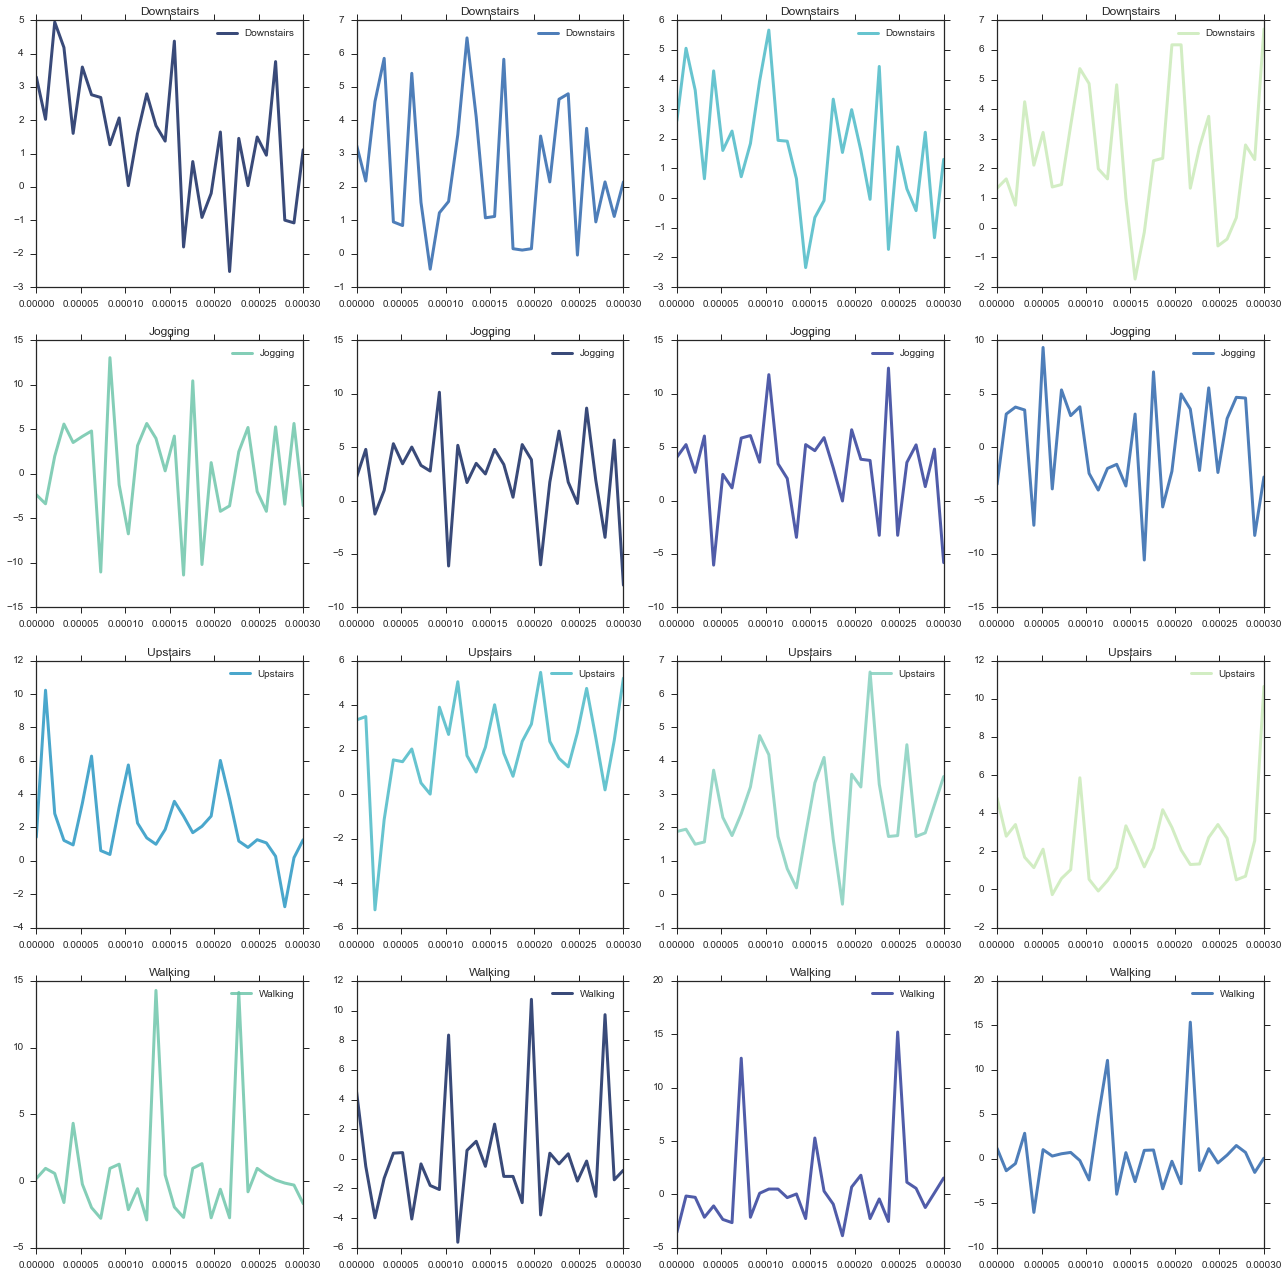

In [7]:
# Get ready to plot 2 subplots as a 4x2 grid, where a subplot is a set of activities
thinkplot.preplot(4, 4, 4)

# Visualize the 4 activities
for plotnum, (g, gdb) in enumerate(db.groupby('activity')):
    # Calculate Waves
    # FIX: framerate is probably not calculated correctly
    zwave = thinkdsp.Wave(gdb['z'].values, framerate=100000)
    
    start0 = 0.01
    window_size = 0.0003
    stride = window_size
    seg_nums = 4
    
    for i in range(seg_nums):
        zseg = zwave.segment(start=start0+i*stride, duration=window_size)
        thinkplot.subplot(4*plotnum+1+i)
        zseg.plot(label=g)
        thinkplot.Config(title=g)

### Visualize Spectrums for a Segment

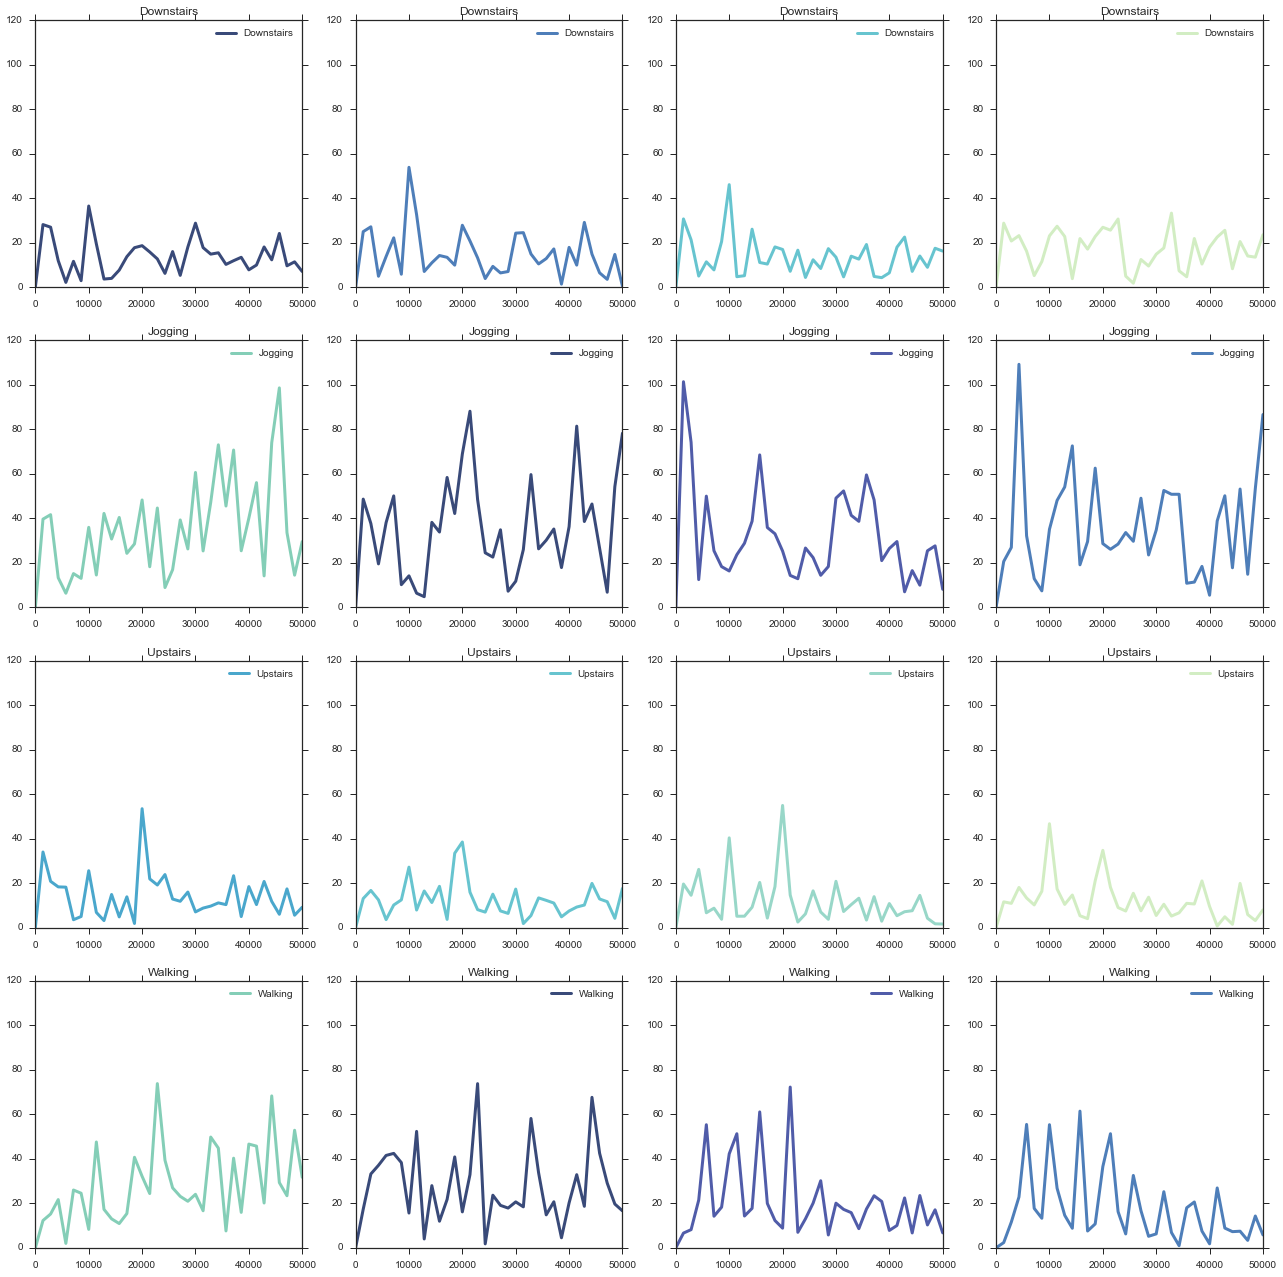

In [8]:
# Get ready to plot 2 subplots as a 4x2 grid
thinkplot.preplot(4, 4, 4)

# Visualize the 4 activities
for plotnum, (g, gdb) in enumerate(db.groupby('activity')):
    # Calculate Waves
    # FIX: framerate is probably not calculated correctly
    zwave = thinkdsp.Wave(gdb['z'].values, framerate=100000)
    
    start0 = 0.01
    window_size = 0.0007
    stride = window_size
    seg_nums = 4
    
    for i in range(seg_nums):
        zseg = zwave.segment(start=start0+i*stride, duration=window_size)
        zseg.unbias()
        spectrum = zseg.make_spectrum()
        thinkplot.subplot(4*plotnum+1+i)
        spectrum.plot(label=g)
        thinkplot.Config(title=g, ylim=[0, 120])

Above are spectrums of the four activities at four consecutive windows. For going up and down the stairs, the spectrums across the four windows are relatively similar. However, walking and jogging have some discrepancies, possibly due to the fact that the time increments are not consistent.

### Pipeline...

In [9]:
amp_dist = {"Downstairs": [],
            "Jogging":[],
            "Upstairs":[],
            "Walking":[]}

# Visualize the 4 activities
for plotnum, (g, gdb) in enumerate(db.groupby('activity')):
    # Calculate Waves
    # FIX: framerate is probably not calculated correctly
    framerate = 100000
    zwave = thinkdsp.Wave(gdb['z'].values, framerate=framerate)
    
    zwave
    start0 = 0
    window_size = 0.0003
    step_size = window_size / 2
    seg_nums = 120
    
    for i in range(seg_nums):
        zseg = zwave.segment(start=start0+i*step_size, duration=window_size)
        zseg.unbias()
        spectrum = zseg.make_spectrum()
        peaks = spectrum.peaks()
        
        # the amplitude of the highest peak
        amp_dist[g].append(peaks[0][0])

In [10]:
for activity, amps in amp_dist.iteritems():
    print activity
    print "mean: ",np.array(amps).mean()
    print "std: ",np.array(amps).std()

Walking
mean:  37.0431545312
std:  8.82675878638
Jogging
mean:  51.0915663118
std:  11.5388338412
Downstairs
mean:  23.9064234624
std:  8.66581555018
Upstairs
mean:  25.5883485274
std:  6.18314819799


In [11]:
from hmmlearn.hmm import GaussianHMM

# Compose Feature Matrix
gmm = {}
hidden_states = {}
X_train = {}
X_test = {}

# arbitrary right now
n_components = 3
train_size = 60

# Train a separate GMM for each activity
for activity, amps in amp_dist.iteritems():
    # Create GMM
    gmm[activity] = GaussianHMM(n_components, covariance_type="diag", n_iter=1000)
    
    # Split into Train and Test Data (No Random Shuffling Now)
    X_train[activity] = np.column_stack([amp_dist[activity][:train_size]])
    X_test[activity] = np.column_stack([amp_dist[activity][train_size:]])
    
    # Fit on Training Data
    gmm[activity].fit([X_train[activity]])

In [16]:
zseg.hamming?

In [12]:
activities = ["Jogging", "Walking", "Upstairs", "Downstairs"]

# For each Test Set
for activity, X in X_test.iteritems():
    print "actual activity: " + activity

    probas = {}

    # Try Out the 4 models
    for model_activity, model in gmm.iteritems():
        probas[model_activity] = model.score(X)
    

    # Which ever has the highest probability will be the model
    max_idx = np.argmax(np.array([probas[activity] for activity in activities]))
    pred_activity = activities[max_idx]
    print "predicted activity: " + pred_activity
    
    print "probas: "
    print probas
    
    print "\n"


actual activity: Walking
predicted activity: Walking
probas: 
{'Walking': -255.26996275862373, 'Downstairs': -332.4094392057084, 'Jogging': -316.98880943384358, 'Upstairs': -406.63858375953095}


actual activity: Downstairs
predicted activity: Downstairs
probas: 
{'Walking': -338.2440955806469, 'Downstairs': -214.72586632611294, 'Jogging': -482.82600799199992, 'Upstairs': -225.06681933279603}


actual activity: Jogging
predicted activity: Jogging
probas: 
{'Walking': -299.59858059327769, 'Downstairs': -299.88107544481215, 'Jogging': -246.59486851741752, 'Upstairs': -1053.0566350873128}


actual activity: Upstairs
predicted activity: Upstairs
probas: 
{'Walking': -316.51546249828732, 'Downstairs': -234.18542811293005, 'Jogging': -462.21027719225617, 'Upstairs': -222.94298177281397}




```n_components``` makes a difference, for classifying between Upstairs and Downstairs.  2 and 4 seem to misclassify, 3 and 5 classify accurately.

##TODOS:

- phone accelerometer
    - collect our own dataset
- timeseries spacing
    - can interpolate given the timestamps
- feature visualization / extraction
    - frequency bins
    - n most dominant frequencies
- machine learning pipeline building
    - Visualizations of labels versus probability classifications
    - Randomized Train Test Split
    
##DONE:

- phone accelerometer
    - install app
- feature visualization / extraction
    - timeseries
    - frequency spectrum
    - power spectrum
    - phase
- machine learning pipeline building
    - Hidden Markov Model
